<a href="https://colab.research.google.com/github/aliikhwan99/Different_stage_of_AD_detection/blob/main/Different_stage_of_AD_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'stage-of-alzheimer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5850466%2F9592054%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241014%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241014T065345Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D28eea7b04b2bcc775e66e5c6ac74df33992537a54a292924db1008e8c18044d0a6b58d01c5cc12a46b3b9ee0a16978269c07db1785a1cbb8f26189542d07f2709458fb99cdfc1dfacbe9d35e0829db90457c037ad6c5601ac3d0b0aaa99e44f16fb498d2944ed48e0613a446187110a7b5dd14a170a750376e3469a419cc9b2f1340e75bdb5e4f685f14a0b2154f08d89ca467aaacf4070915d8a071c99e1b3827aa8087c4ffd892acf86e6dc39520996e537e4b771dc7c38627ac29fe49f79b7e7d33395472b09da37ff8b1275eedcbfdd282db817808f9fbc3dd054588f6abd29572a9df7e20341d8d1576b74f3c2b2a1d86fda26e144b7d05b840a8248288'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# Visualize DICOM file (rs-fMRI)

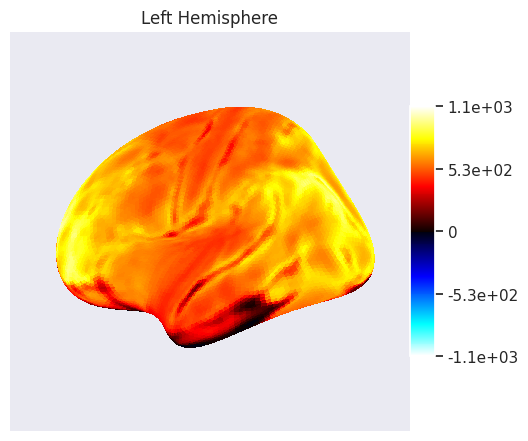

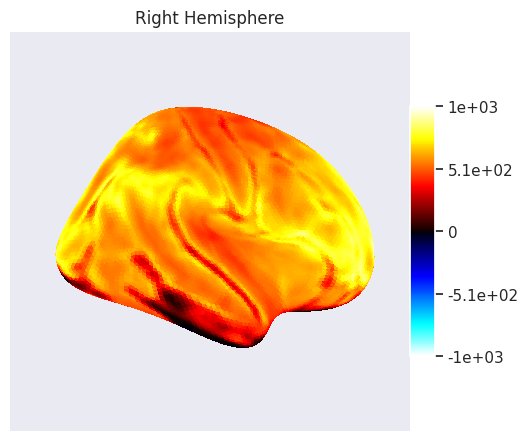

In [ ]:
from nilearn import image

# Load your fMRI image
fmri_img = image.index_img(fmri_img, 0)  # Select the first volume (or another index)

# Project the selected volume to the cortical surface
texture_left = surface.vol_to_surf(fmri_img, fsaverage.pial_left)
texture_right = surface.vol_to_surf(fmri_img, fsaverage.pial_right)

# Plot the projected data on the brain surface
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, hemi='left', title='Left Hemisphere')
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right, hemi='right', title='Right Hemisphere')

plotting.show()


# Averaging across time (optional)

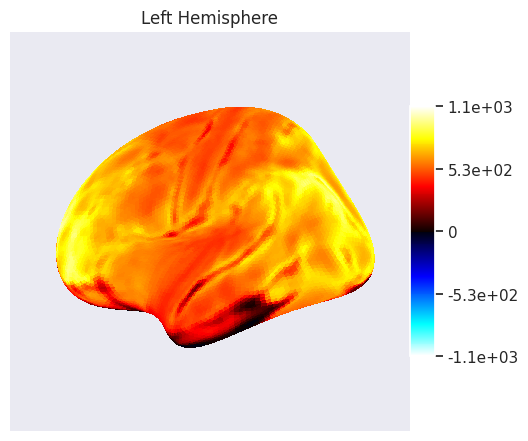

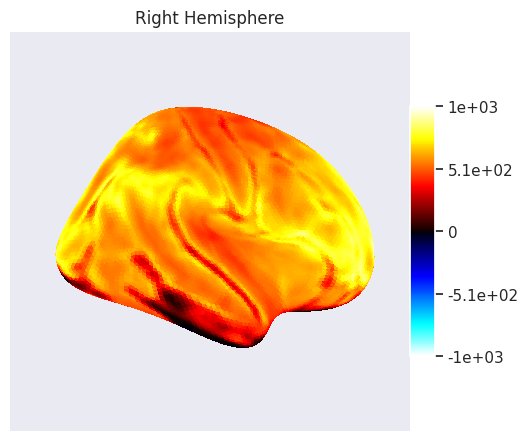

In [ ]:
# Averaging the fMRI image across time
fmri_img_mean = image.mean_img(fmri_img)

# Project to surface
texture_left = surface.vol_to_surf(fmri_img_mean, fsaverage.pial_left)
texture_right = surface.vol_to_surf(fmri_img_mean, fsaverage.pial_right)

# Plot the projected data
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, hemi='left', title='Left Hemisphere')
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right, hemi='right', title='Right Hemisphere')

plotting.show()


# ORGIGIN

In [ ]:
!apt-get install -y dcm2niix


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libturbojpeg libyaml-cpp0.6
Suggested packages:
  pigz
The following NEW packages will be installed:
  dcm2niix libturbojpeg libyaml-cpp0.6
0 upgraded, 3 newly installed, 0 to remove and 46 not upgraded.
Need to get 456 kB of archives.
After this operation, 1782 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 libturbojpeg amd64 2.0.3-0ubuntu1.20.04.3 [156 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libyaml-cpp0.6 amd64 0.6.2-4ubuntu1 [124 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 dcm2niix amd64 1.0.20181125-1build1 [176 kB]
Fetched 456 kB in 0s (4104 kB/s) 
Selecting previously unselected package libturbojpeg:amd64.
(Reading database ... 115958 files and directories currently installed.)
Preparing to unpack .../libturbojpeg_2.0.3-0ubuntu1.

In [ ]:
import subprocess

dicom_directory = '/kaggle/input/stage-of-alzheimer/NC/ADNI/002_S_0295/Resting_State_fMRI/2011-06-02_07_56_36.0/I238623'
output_directory = '/kaggle/working'  # Specify where you want to save the NIfTI file

# Run dcm2niix and capture output and error messages
result = subprocess.run(['dcm2niix', '-z', 'y', '-f', '%p_%s', '-o', output_directory, dicom_directory],
                        capture_output=True, text=True)

# Print the output and error messages
print("Output:\n", result.stdout)
print("Error:\n", result.stderr)


Output:
 Compression will be faster with 'pigz' installed
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 6720 DICOM file(s)
swizzling 3rd and 4th dimensions (XYTZ -> XYZT), assuming interslice distance is 3.312500
Using RWVSlope:RWVIntercept = 1.22222:0
 Philips Scaling Values RS:RI:SS = 1.22222:0:0.000600573 (see PMC3998685)
Convert 6720 DICOM as /kaggle/working/Resting_State_fMRI_501 (64x64x48x140)
Conversion required 79.538442 seconds (15.704946 for core code).

Error:
 


In [ ]:
import os

print("Converted files:")
print(os.listdir(output_directory))


Converted files:
['Resting_State_fMRI_501.nii.gz', '.virtual_documents', 'Resting_State_fMRI_501.json']


/opt/conda/lib/python3.10/site-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '2.16.124.113543.6006.99.05683015139310564330'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/opt/conda/lib/python3.10/site-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '2.16.124.113543.6006.99.06282883507200984267'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/opt/conda/lib/python3.10/site-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '2.16.124.113543.6006.99.06279230344779385614'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/opt/conda/lib/python3.10/site-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '2.16.

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 180
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 2.16.124.113543.6006.99.05683015139310564330
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 2.16.124.113543.6006.99.3688024390674402269
-------------------------------------------------
(0008,0000) Group Length                        UL: 1346
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M_FFE', 'M', 'FFE']
(0008,0013) Instance Creation Time              TM: '131928'
(0008,0014) Instance Creator UID                UI: 2.16.124.113543.6006.99.3051493601938435224
(0008,0016) SOP Class UID                       UI: MR Image Sto

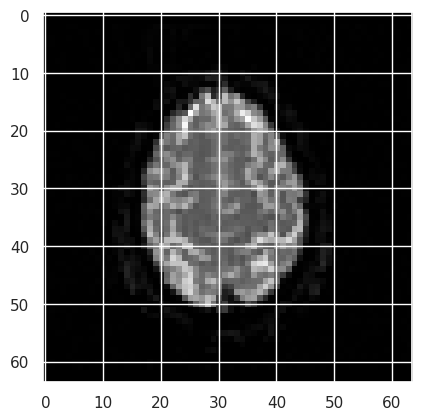

In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt

# Define your DICOM directory
dicom_directory = '/kaggle/input/stage-of-alzheimer/MCI/ADNI/002_S_1155/Resting_State_fMRI/2012-12-20_12_16_12.0/I352947'

# List all files in the directory
files = os.listdir(dicom_directory)

# Filter to only get DICOM files (optional if there are non-DICOM files)
dicom_files = [f for f in files if f.endswith('.dcm')]

# Check if any DICOM files exist
if len(dicom_files) == 0:
    print("No DICOM files found in the directory.")
else:
    # Load the first DICOM file
    dicom_file = os.path.join(dicom_directory, dicom_files[0])
    ds = pydicom.dcmread(dicom_file)

    # Print metadata
    print(ds)

    # Extract and plot the image data (if available)
    plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
    plt.show()


# Normal

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 180
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 2.16.124.113543.6006.99.6446586041935783947
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 2.16.124.113543.6006.99.08409762046509091250
-------------------------------------------------
(0008,0000) Group Length                        UL: 1336
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M_FFE', 'M', 'FFE']
(0008,0013) Instance Creation Time              TM: '104929'
(0008,0014) Instance Creator UID                UI: 2.16.124.113543.6006.99.3051493601938435224
(0008,0016) SOP Class UID                       UI: MR Image Sto

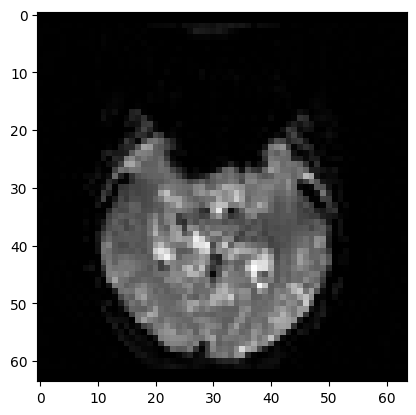

In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt

# Define your DICOM directory
dicom_directory = '/kaggle/input/stage-of-alzheimer/NC/ADNI/002_S_0295/Resting_State_fMRI/2011-06-02_07_56_36.0/I238623'

# List all files in the directory
files = os.listdir(dicom_directory)

# Filter to only get DICOM files (optional if there are non-DICOM files)
dicom_files = [f for f in files if f.endswith('.dcm')]

# Check if any DICOM files exist
if len(dicom_files) == 0:
    print("No DICOM files found in the directory.")
else:
    # Load the first DICOM file
    dicom_file = os.path.join(dicom_directory, dicom_files[1])
    ds = pydicom.dcmread(dicom_file)

    # Print metadata
    print(ds)

    # Extract and plot the image data (if available)
    plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
    plt.show()


# Visualizing the Connectivity Matrix

# Normal

Directory exists: /kaggle/input/stage-of-alzheimer/NC/ADNI/002_S_0295/Resting_State_fMRI/2011-06-02_07_56_36.0/I238623
Shape of fMRI data: (6720, 64, 64)
Shape of time series data: (4096, 6720)
Shape of connectivity matrix: (4096, 4096)

Added README.md to /root/nilearn_data


Dataset created in /root/nilearn_data/aal_SPM12



 ...done. (1 seconds, 0 min)
Extracting data from /root/nilearn_data/aal_SPM12/a4f2a6316ec7f29f771edef840308edf/aal_for_SPM12.tar.gz..... done.


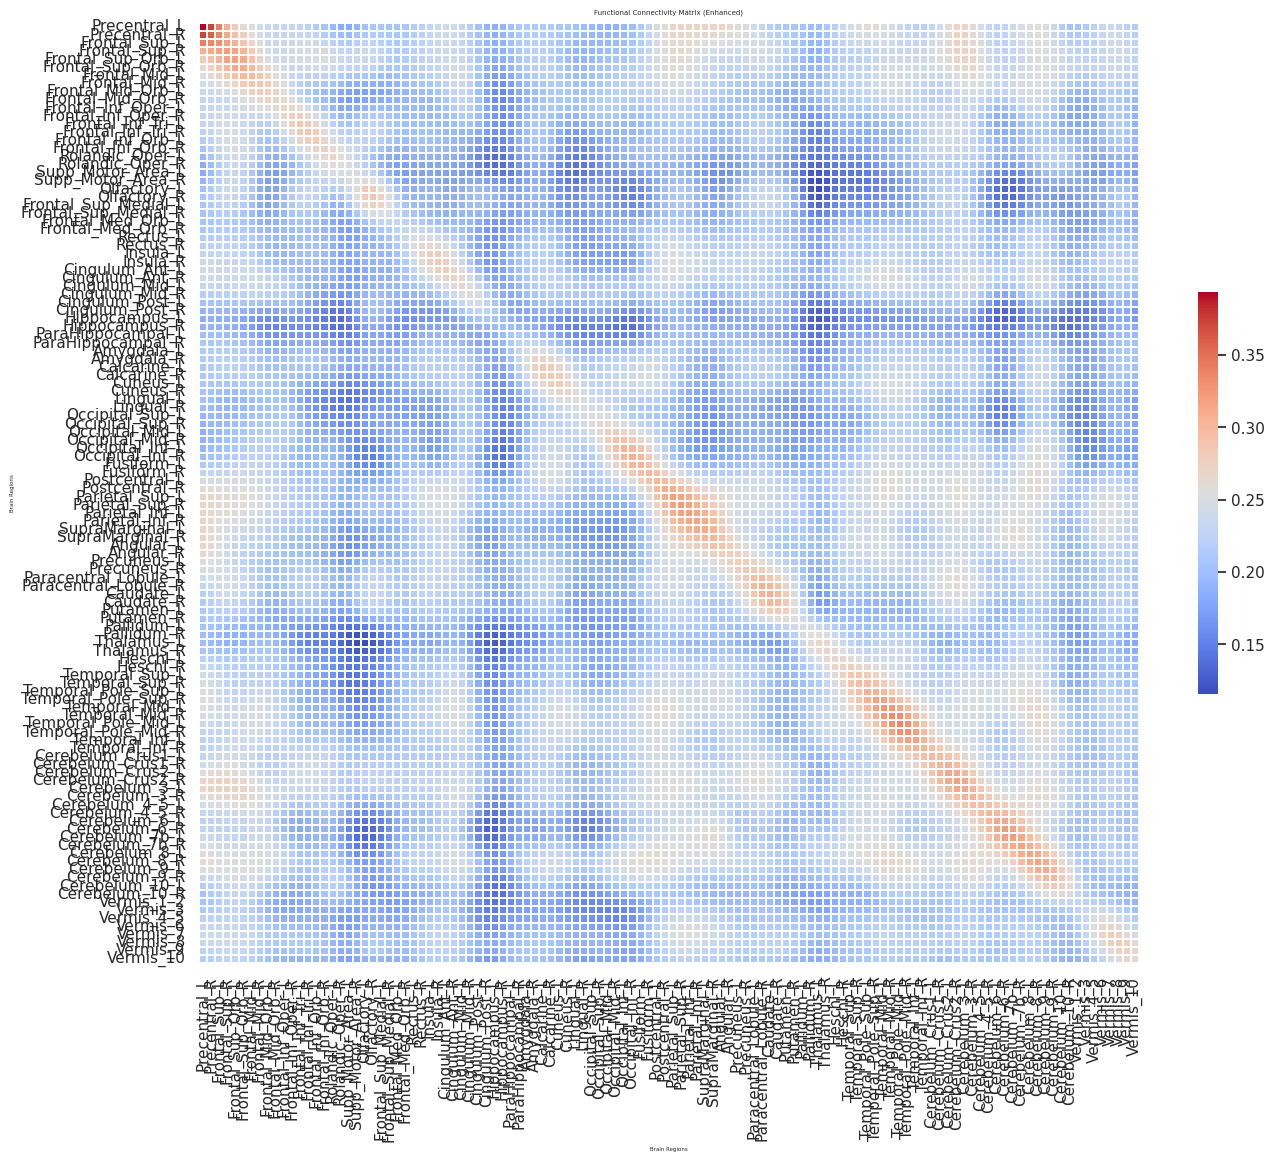

In [ ]:
import os
import numpy as np
import pydicom  # Make sure pydicom is installed in your environment
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import datasets
from scipy.ndimage import gaussian_filter  # Import Gaussian filter

# Path to the directory containing the DICOM files
dicom_directory = '/kaggle/input/stage-of-alzheimer/NC/ADNI/002_S_0295/Resting_State_fMRI/2011-06-02_07_56_36.0/I238623'

# Check if the directory exists
if not os.path.exists(dicom_directory):
    print(f"Directory not found: {dicom_directory}")
else:
    print(f"Directory exists: {dicom_directory}")

    # Load the DICOM files
    def load_dicom_series(directory):
        dicom_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
        dicom_files.sort()  # Sort the files to maintain order
        images = []
        for dicom_file in dicom_files:
            ds = pydicom.dcmread(dicom_file)
            images.append(ds.pixel_array)  # Append pixel data
        return np.array(images)

    # Load your fMRI data
    fmri_data = load_dicom_series(dicom_directory)
    print(f"Shape of fMRI data: {fmri_data.shape}")  # (time_points, height, width)

# Function to extract time series from the 4D fMRI data
def extract_time_series(fmri_data):
    # Get the shape of the fMRI data
    time_points, height, width = fmri_data.shape[0], fmri_data.shape[1], fmri_data.shape[2]

    # Reshape to a 2D array: (voxels, time_points)
    reshaped_data = fmri_data.reshape(-1, time_points)
    return reshaped_data

# Extract time series from the fMRI data
time_series = extract_time_series(fmri_data)
print(f"Shape of time series data: {time_series.shape}")  # (voxels, time_points)

# Function to compute the functional connectivity matrix
def compute_functional_connectivity(time_series):
    # Calculate the correlation matrix
    connectivity_matrix = np.corrcoef(time_series)
    return connectivity_matrix

# Compute the functional connectivity matrix
connectivity_matrix = compute_functional_connectivity(time_series)
print(f"Shape of connectivity matrix: {connectivity_matrix.shape}")  # (voxels, voxels)

# Apply Gaussian filter to the functional connectivity matrix
smoothed_connectivity_matrix = gaussian_filter(connectivity_matrix, sigma=2)  # You can adjust sigma value

# Load the AAL brain atlas and its labels
atlas = datasets.fetch_atlas_aal()
atlas_labels = atlas['labels']  # Get brain region labels

# Truncate the connectivity matrix if it's larger than the number of available atlas labels
num_labels = len(atlas_labels)
if smoothed_connectivity_matrix.shape[0] > num_labels:
    truncated_connectivity_matrix = smoothed_connectivity_matrix[:num_labels, :num_labels]
else:
    truncated_connectivity_matrix = smoothed_connectivity_matrix  # Use the original if no truncation needed

# Function to plot a clearer connectivity matrix with enhancements
def plot_enhanced_connectivity_matrix(connectivity_matrix, labels):
    plt.figure(figsize=(14, 12), dpi=100)  # Increase size and DPI
    sns.set(font_scale=1)  # Increase font scale for better readability
    sns.heatmap(connectivity_matrix, cmap='coolwarm', square=True,
                xticklabels=labels[:connectivity_matrix.shape[0]],
                yticklabels=labels[:connectivity_matrix.shape[0]],
                cbar_kws={"shrink": .4}, linewidths=.2)  # Add lines between cells for clarity
    plt.title('Functional Connectivity Matrix (Enhanced)', fontsize=5)
    plt.xlabel('Brain Regions', fontsize=4)
    plt.ylabel('Brain Regions', fontsize=4)
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to fit everything well
    plt.show()

# Plot the enhanced connectivity matrix with the AAL labels
plot_enhanced_connectivity_matrix(truncated_connectivity_matrix, atlas_labels)


Directory exists: /kaggle/input/stage-of-alzheimer/NC/ADNI/002_S_0295/Resting_State_fMRI/2011-06-02_07_56_36.0/I238623
Shape of fMRI data: (6720, 64, 64)
Shape of time series data: (4096, 6720)
Shape of connectivity matrix: (4096, 4096)


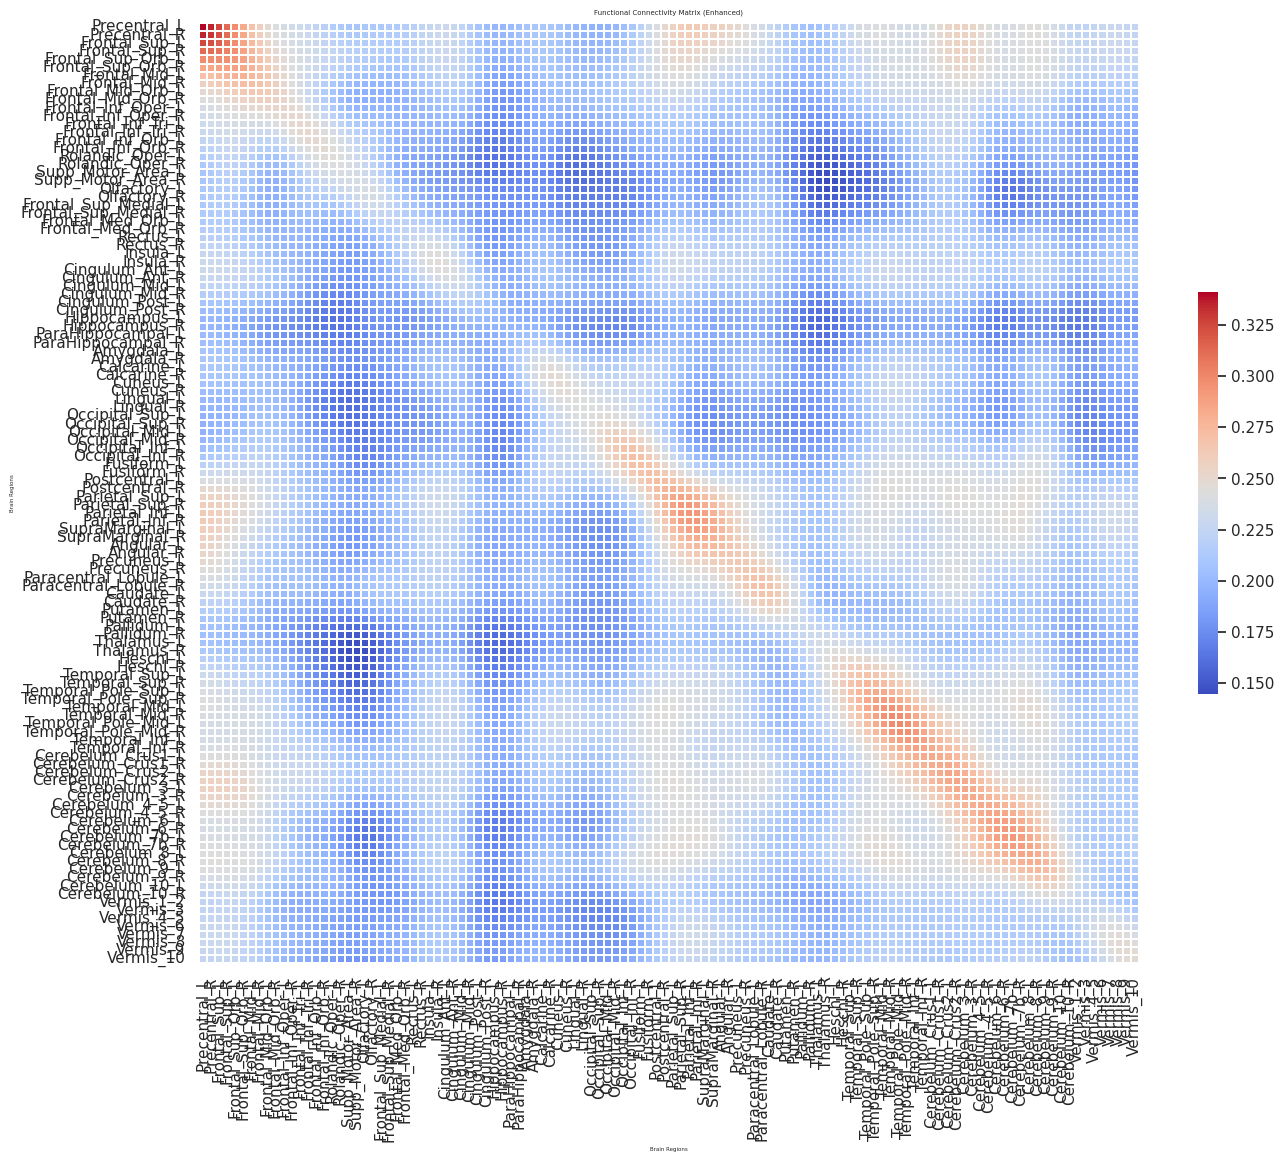

In [ ]:
import os
import numpy as np
import pydicom  # Make sure pydicom is installed in your environment
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import datasets
from scipy.ndimage import gaussian_filter  # Import Gaussian filter
from scipy.ndimage import median_filter

# Path to the directory containing the DICOM files
dicom_directory = '/kaggle/input/stage-of-alzheimer/NC/ADNI/002_S_0295/Resting_State_fMRI/2011-06-02_07_56_36.0/I238623'

# Check if the directory exists
if not os.path.exists(dicom_directory):
    print(f"Directory not found: {dicom_directory}")
else:
    print(f"Directory exists: {dicom_directory}")

    # Load the DICOM files
    def load_dicom_series(directory):
        dicom_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
        dicom_files.sort()  # Sort the files to maintain order
        images = []
        for dicom_file in dicom_files:
            ds = pydicom.dcmread(dicom_file)
            images.append(ds.pixel_array)  # Append pixel data
        return np.array(images)

    # Load your fMRI data
    fmri_data = load_dicom_series(dicom_directory)
    print(f"Shape of fMRI data: {fmri_data.shape}")  # (time_points, height, width)

# Function to extract time series from the 4D fMRI data
def extract_time_series(fmri_data):
    # Get the shape of the fMRI data
    time_points, height, width = fmri_data.shape[0], fmri_data.shape[1], fmri_data.shape[2]

    # Reshape to a 2D array: (voxels, time_points)
    reshaped_data = fmri_data.reshape(-1, time_points)
    return reshaped_data

# Extract time series from the fMRI data
time_series = extract_time_series(fmri_data)
print(f"Shape of time series data: {time_series.shape}")  # (voxels, time_points)

# Function to compute the functional connectivity matrix
def compute_functional_connectivity(time_series):
    # Calculate the correlation matrix
    connectivity_matrix = np.corrcoef(time_series)
    return connectivity_matrix

# Apply median filter to reduce noise
filtered_matrix = median_filter(connectivity_matrix, size=3)  # Adjust size for the window size

# Compute the functional connectivity matrix
connectivity_matrix = compute_functional_connectivity(time_series)
print(f"Shape of connectivity matrix: {connectivity_matrix.shape}")  # (voxels, voxels)

# Apply Gaussian filter to the functional connectivity matrix
smoothed_connectivity_matrix = gaussian_filter(connectivity_matrix, sigma=3)  # You can adjust sigma value

# Load the AAL brain atlas and its labels
atlas = datasets.fetch_atlas_aal()
atlas_labels = atlas['labels']  # Get brain region labels

# Truncate the connectivity matrix if it's larger than the number of available atlas labels
num_labels = len(atlas_labels)
if smoothed_connectivity_matrix.shape[0] > num_labels:
    truncated_connectivity_matrix = smoothed_connectivity_matrix[:num_labels, :num_labels]
else:
    truncated_connectivity_matrix = smoothed_connectivity_matrix  # Use the original if no truncation needed

# Function to plot a clearer connectivity matrix with enhancements
def plot_enhanced_connectivity_matrix(connectivity_matrix, labels):
    plt.figure(figsize=(14, 12), dpi=100)  # Increase size and DPI
    sns.set(font_scale=1)  # Increase font scale for better readability
    sns.heatmap(connectivity_matrix, cmap='coolwarm', square=True,
                xticklabels=labels[:connectivity_matrix.shape[0]],
                yticklabels=labels[:connectivity_matrix.shape[0]],
                cbar_kws={"shrink": .4}, linewidths=.2)  # Add lines between cells for clarity
    plt.title('Functional Connectivity Matrix (Enhanced)', fontsize=5)
    plt.xlabel('Brain Regions', fontsize=4)
    plt.ylabel('Brain Regions', fontsize=4)
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to fit everything well
    plt.show()

# Plot the enhanced connectivity matrix with the AAL labels
plot_enhanced_connectivity_matrix(truncated_connectivity_matrix, atlas_labels)


# Actual brain activity position

In [ ]:
pip install nilearn matplotlib


Note: you may need to restart the kernel to use updated packages.


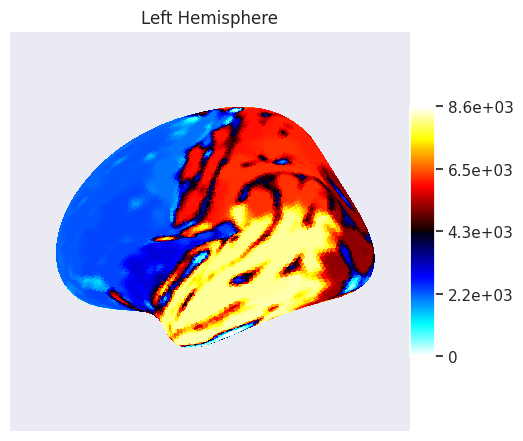

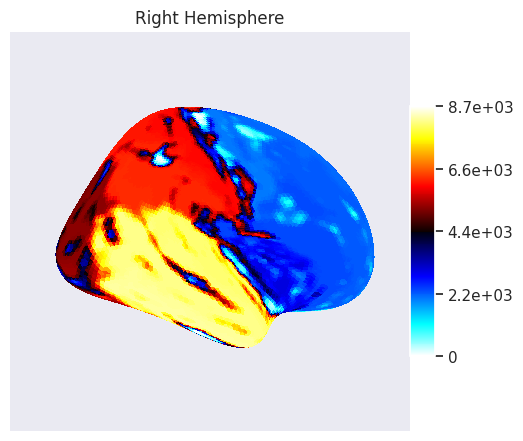

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, datasets, surface
from nilearn.input_data import NiftiLabelsMasker

# Mock example of your connectivity matrix; replace with your actual matrix
connectivity_matrix = np.random.rand(90, 90)  # Example connectivity matrix (90 regions)

# Load the AAL atlas
atlas = datasets.fetch_atlas_aal()
atlas_filename = atlas['maps']  # AAL atlas NIfTI file
atlas_labels = atlas['labels']  # Get brain region labels

# Load a standard brain surface for visualization
fsaverage = datasets.fetch_surf_fsaverage()

# Use NiftiLabelsMasker to extract time series data based on atlas regions
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)

# Prepare a 1D array to represent the functional connectivity on the brain surface
left_connectivity = np.zeros(45)  # For left hemisphere
right_connectivity = np.zeros(45)  # For right hemisphere

# Map connectivity values to left and right hemispheres
for i in range(len(atlas_labels)):
    if i < 45:  # Left hemisphere
        left_connectivity[i] = connectivity_matrix[i, :].mean()  # Example aggregation
    elif i < 90:  # Right hemisphere
        right_index = i - 45  # Adjust index for right hemisphere
        right_connectivity[right_index] = connectivity_matrix[i, :].mean()  # Example aggregation

# Project the AAL atlas regions onto the brain surface
texture_left = surface.vol_to_surf(atlas_filename, fsaverage.pial_left)
texture_right = surface.vol_to_surf(atlas_filename, fsaverage.pial_right)

# Plot the left hemisphere
plotting.plot_surf_stat_map(fsaverage['infl_left'],
                            stat_map=texture_left,
                            hemi='left',
                            view='lateral',
                            title='Left Hemisphere',
                            colorbar=True)

# Plot the right hemisphere
plotting.plot_surf_stat_map(fsaverage['infl_right'],
                            stat_map=texture_right,
                            hemi='right',
                            view='lateral',
                            title='Right Hemisphere',
                            colorbar=True)

plt.show()
